# Coronavirus Research Project

## Overview

This project investigated the effect of coronaviurs to baby, toddler, teenager, young adult, middle-age and elder.

## Import Packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

#import geopandas as gpd

In [3]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## Coronavirus API

In [70]:
url = 'https://coronavirus-tracker-api.herokuapp.com/v2/locations'

random = np.random.uniform(0, 1, 501)
# time.sleep(random[i])
params = {  
            'source': 'csbs',
            'country_code': 'US',           
            'timelines': 1
          }

response = requests.get(url, params)
d = response.json()

In [53]:
pd.DataFrame(d['locations'][248]['timelines']['deaths'])

,timeline
2020-01-22T00:00:00Z,0
2020-01-23T00:00:00Z,0
2020-01-24T00:00:00Z,0
2020-01-25T00:00:00Z,0
2020-01-26T00:00:00Z,0
...,...
2020-12-30T00:00:00Z,342318
2020-12-31T00:00:00Z,345737
2021-01-01T00:00:00Z,347788
2021-01-02T00:00:00Z,350186


<AxesSubplot:>

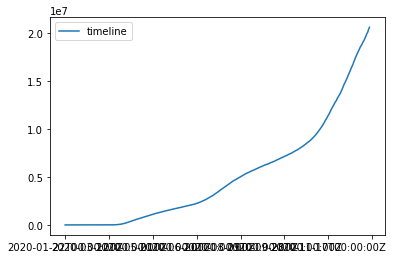

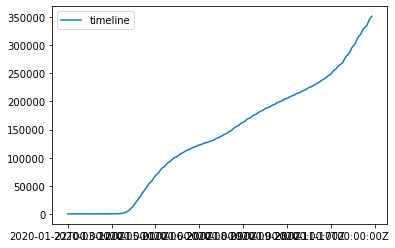

In [54]:
pd.DataFrame(d['locations'][248]['timelines']['confirmed']).plot()
pd.DataFrame(d['locations'][248]['timelines']['deaths']).plot()

In [74]:
df = pd.DataFrame(d['locations'])

In [75]:
df

,id,country,country_code,country_population,province,county,last_updated,coordinates,latest
0,0,US,US,327167434,California,Los Angeles,2021-01-04T13:31:00Z,"{'latitude': '34.053490000000004', 'longitude'...","{'confirmed': 818698, 'deaths': 10773, 'recove..."
1,1,US,US,327167434,California,San Bernardino,2021-01-04T13:31:00Z,"{'latitude': '34.10524', 'longitude': '-117.29...","{'confirmed': 195663, 'deaths': 1447, 'recover..."
2,2,US,US,327167434,California,Riverside,2021-01-04T13:31:00Z,"{'latitude': '33.98171', 'longitude': '-117.37...","{'confirmed': 180553, 'deaths': 1985, 'recover..."
3,3,US,US,327167434,California,San Diego,2021-01-04T13:31:00Z,"{'latitude': '32.71568', 'longitude': '-117.16...","{'confirmed': 168020, 'deaths': 1592, 'recover..."
4,4,US,US,327167434,California,Orange,2021-01-04T13:31:00Z,"{'latitude': '33.78787', 'longitude': '-117.85...","{'confirmed': 161589, 'deaths': 1901, 'recover..."
...,...,...,...,...,...,...,...,...,...
3151,3151,US,US,327167434,US Virgin Islands,St. Thomas,2021-01-04T13:31:00Z,"{'latitude': '18.34899', 'longitude': '-64.930...","{'confirmed': 1028, 'deaths': 0, 'recovered': 0}"
3152,3152,US,US,327167434,US Virgin Islands,St. Croix,2021-01-04T13:31:00Z,"{'latitude': '17.73563', 'longitude': '-64.747...","{'confirmed': 829, 'deaths': 0, 'recovered': 0}"
3153,3153,US,US,327167434,US Virgin Islands,St. John,2021-01-04T13:31:00Z,"{'latitude': '18.33870409', 'longitude': '-64....","{'confirmed': 174, 'deaths': 0, 'recovered': 0}"
3154,3154,US,US,327167434,Northern Mariana Islands,Northern Mariana Islands,2021-01-04T13:31:00Z,"{'latitude': '15.188824770000052', 'longitude'...","{'confirmed': 31, 'deaths': 2, 'recovered': 0}"


## API

In [194]:
url = 'https://api.covidtracking.com/v1/us/daily.json'

response = requests.get(url)
d = response.json()

In [195]:
pd.DataFrame(d)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20210104,56,20560549.0,198034096.0,9463.0,128210.0,699971.0,23435.0,37586.0,7930.0,...,256914140,2021-01-04T24:00:00Z,0,0,1545,4029,1257838,177669,1638082,9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c
1,20210103,56,20382880.0,196776258.0,9407.0,125562.0,695942.0,23243.0,37433.0,7939.0,...,255276058,2021-01-03T24:00:00Z,0,0,1461,2226,1001197,207726,1444369,fd495d4591df97f8297b69a93a38209da53a5d30
2,20210102,56,20175154.0,195775061.0,9356.0,123614.0,693716.0,23133.0,37309.0,7910.0,...,253831689,2021-01-02T24:00:00Z,0,0,2395,3051,1358739,278680,2077336,0a41916c227cf908081548d26fcad961a5f00397
3,20210101,56,19896474.0,194416322.0,11506.0,125047.0,690665.0,23255.0,37196.0,7990.0,...,251754353,2021-01-01T24:00:00Z,0,0,2596,4507,872785,179852,1276261,7641ed39d70f7ed6a52a1068b5c36f6c91c8d190
4,20201231,56,19716622.0,193543537.0,14931.0,125379.0,686158.0,23099.0,37066.0,8003.0,...,250478092,2020-12-31T24:00:00Z,0,0,3287,4290,1120447,223036,1748878,87a8179b8e103555fec80788c35221afd086662a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,20200117,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-17T24:00:00Z,0,0,0,0,0,0,0,5fd7ed7fb0f83565ea0aaaf5ff6104e5860be2d6
354,20200116,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-16T24:00:00Z,0,0,0,0,0,0,0,4c0f2ea879eefec1a18a93bcd8a382ea56cd452d
355,20200115,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-15T24:00:00Z,0,0,0,0,0,0,0,8a449023413eea473277416e9e30ae126c6af047
356,20200114,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2020-01-14T24:00:00Z,0,0,0,0,0,0,0,fe399466a3dfbe0221a18ed5cacb39a3882d72f8


In [196]:
url = 'https://api.covidtracking.com/v1/us/current.json'

response = requests.get(url)
d = response.json()

In [197]:
d

[{'date': 20210104,
  'states': 56,
  'positive': 20560549,
  'negative': 198034096,
  'pending': 9463,
  'hospitalizedCurrently': 128210,
  'hospitalizedCumulative': 699971,
  'inIcuCurrently': 23435,
  'inIcuCumulative': 37586,
  'onVentilatorCurrently': 7930,
  'onVentilatorCumulative': 3692,
  'recovered': 8299717,
  'dateChecked': '2021-01-04T24:00:00Z',
  'death': 344808,
  'hospitalized': 699971,
  'totalTestResults': 256914140,
  'lastModified': '2021-01-04T24:00:00Z',
  'total': 0,
  'posNeg': 0,
  'deathIncrease': 1545,
  'hospitalizedIncrease': 4029,
  'negativeIncrease': 1257838,
  'positiveIncrease': 177669,
  'totalTestResultsIncrease': 1638082,
  'hash': '9a5d7bba3805b8932e540b0cfbc0ce782ef9b94c'}]

## Zip API

In [133]:
from requests.auth import HTTPBasicAuth

In [ ]:
f = open('api.json')
api_key = json.load(f)

In [164]:
url = f"https://service.zipapi.us/hospital/radius/11367?X-API-KEY={api_key['zip_api']['api']}"

params = {  
            'radius': 20
          }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [169]:
pd.DataFrame(d['data'])

,Zip,Name,Address,City,State,telephone,latitude,longitude,website,beds,naics_desc,helipad,population,county,distance
0,11355,NEW YORK HOSPITAL QUEENS,56 45 MAIN ST,FLUSHING,NY,(718) 670-2000,40.7467722760001,-73.8254163829999,http://www.nyhq.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,519,QUEENS,1.2056043406980474
1,11375,FOREST HILLS HOSPITAL,102-01 66 ROAD,FOREST HILLS,NY,(516) 562-4060,40.7289946700001,-73.8515067069999,https://www.northwell.edu/find-care/locations/...,222,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,222,QUEENS,1.2667295458905368
2,11432,QUEENS HOSPITAL CENTER,82-68 164TH ST,JAMAICA,NY,(718) 883-2350,40.7170722130001,-73.804556192,http://www.nyc.gov/html/hhc/qhc/html/home/home...,247,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,247,QUEENS,1.464323443176699
3,11355,FLUSHING HOSPITAL MEDICAL CENTER,45 TH AVE & PARSONS BLVD,FLUSHING,NY,(718) 670-5918,40.7554099230001,-73.816465518,http://www.flushinghospital.org,293,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,293,QUEENS,1.8859069570899702
4,11414,JAMAICA HOSPITAL MEDICAL CENTER,8900 VAN WYCK EXPRESSWAY,JAMAICA,NY,(718) 206-6000,40.700103647,-73.816114892,http://jamaicahospital.org/,408,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,408,QUEENS,2.1063832945759255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,07107,COLUMBUS HOSPITAL,495 NORTH 13TH STREET,NEWARK,NJ,(973) 587-7712,40.772604012,-74.1867090869999,http://www.columbusltach.org,63,SPECIALTY (EXCEPT PSYCHIATRIC AND SUBSTANCE AB...,N,63,ESSEX,19.046704035393592
118,07103,THE UNIVERSITY HOSPITAL,150 BERGEN STREET,NEWARK,NJ,(973) 972-5658,40.740603133,-74.191061732,http://www.uhnj.org/,519,GENERAL MEDICAL AND SURGICAL HOSPITALS,Y,519,ESSEX,19.05932172210713
119,10522,ST. JOHN'S RIVERSIDE HOSPITAL - DOBBS FERRY,128 ASHFORD AVE,DOBBS FERRY,NY,(914) 693-0700,41.014392248,-73.861919649,http://www.riversidehealth.org,12,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,12,WESTCHESTER,19.775034789331748
120,07652,BERGEN REGIONAL MEDICAL CENTER,230 EAST RIDGEWOOD AVENUE,PARAMUS,NJ,(201) 967-4000,40.956667775,-74.0629917159999,http://www.bergenregional.com,510,GENERAL MEDICAL AND SURGICAL HOSPITALS,N,510,BERGEN,19.95883250040654


In [181]:
url = f"https://service.zipapi.us/age/zipcode/11367?X-API-KEY={api_key['zip_api']['api']}"

# params = {  
#             'fields': ['male_age','female_age']
#           }

response = requests.get(url, params,  auth=HTTPBasicAuth(api_key['zip_api']['email'], api_key['zip_api']['password']))
d = response.json()

In [182]:
d

{'status': True,
 'data': {'median_age': '34.2', 'male_age': '32.1', 'female_age': '36.3'}}

## Web Scraping

# Data Clean and Analysis

# Visualization

# Conclusion

"{'zip_api':{'api':'3bc0920e2b6f5a6852a156cda340ddb4','email': 'chen.ning345@gmail.com','password': 'zp-cn1988.34.5'}}"